In [1]:

import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import betabinom

from plot_params import *
from pybedtools import BedTool

In [2]:

window_bed = BedTool('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_df = pd.read_csv(window_bed.fn, sep = '\t')

pum_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_pum2.homer.motif', sep = '\t')
pum_motif = pum_motif.loc[pum_motif['Motif Name']=='1-TGTATATA']
pum_motif['windowstrand']=pum_motif['PositionID'].map(window_df.set_index('name')['strand'])
pum_motif.dropna(inplace = True)
pum_motif = pum_motif.loc[pum_motif['Strand']==pum_motif['windowstrand']]

rbfox2_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_rbfox2.homer.motif', sep = '\t')
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Motif Name'].isin(
    ['1-TGCATG', '2-GCATST', '3-AGCATG','8-TGCACA', '9-TGCACG']                                                            
)
]
rbfox2_motif['windowstrand']=rbfox2_motif['PositionID'].map(window_df.set_index('name')['strand'])
rbfox2_motif.dropna(inplace = True)
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Strand']==rbfox2_motif['windowstrand']]


In [3]:
# eCLIP binding sites
ground_truth_skipper = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper.sum().sort_values()

EIF3G         213
ZC3H11A      4722
PUM2         7147
RBFOX2      12206
DDX3        12334
LIN28B      26668
IGF2BP2     28834
SF3B4       44025
FAM120A     50622
PRPF8      102243
dtype: int64

In [4]:
basedir=Path('/tscc/nfs/home/hsher/ps-yeolab5/Dan_ABC_singleplex_SLBP')

In [5]:
def is_goldstandard(row):
    return ('UTR3' in row['feature_types'] or 'CDS_STOP' in row['feature_types']) and (
        row['gene_name'].startswith('H1') or row['gene_name'].startswith('H2') or
        row['gene_name'].startswith('H3') or row['gene_name'].startswith('H4'))
        

In [6]:
# find all files
beta_external = list(basedir.glob('beta-mixture_external/*/*window_score.tsv'))

In [7]:
def accuracy_among_topk(score, truth, k):
    indicies = score.sort_values(ascending = False).iloc[:k].index
    return truth.loc[indicies].mean()


In [8]:
cdict = dict(zip(['oligoCLIP_ctrlSpike_rep1', 'oligoCLIP_ctrlSpike_rep2',
       'oligoCLIP_ctrlBead_rep1', 'oligoCLIP_ctrlBead_rep2',
                  'oligoCLIP_IgG_rep2','oligoCLIP_IgG_rep1',
       'eCLIP_SLBP_SMInput', 'ABC_K562_summed'
       , 'K562_totalRNAseq'],
        
                 ['tomato', 'red',
                  'gold', 'orange', 
                  'seagreen', 'limegreen',
                  'grey', 
                  'orchid', 
                  'royalblue']
                ))

In [9]:
rename_dict = {'K562_totalRNAseq': 'totalRNAseq',
               'eCLIP_SLBP_SMInput': 'eCLIP_SMInput', 
                       'oligoCLIP_IgG_rep1': 'Barcode-IgG', 
               'oligoCLIP_ctrlBead_rep1': 'Bead-only control',
                       'oligoCLIP_ctrlSpike_rep1':'Spike-in',
               'oligoCLIP_IgG_rep2': 'Barcode-IgG', 
               'oligoCLIP_ctrlBead_rep2': 'Bead-only control',
                       'oligoCLIP_ctrlSpike_rep2':'Spike-in',
               'ABC_K562_summed': 'Sum of multiplex',
               'ABC_K562_summed_rep4': 'Sum of multiplex'
              }

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from collections import OrderedDict
stat = []
topk = []
cnts = []
cnts_eclip = []
skipper_cnts = []

######## BBM #######
for file in beta_external:
    rep = file.name.split('.')[0]
    ctrl = rename_dict[file.parent.name]
    
    df = pd.read_csv(file, sep = '\t')

    # annotation truth
    df['is_histone']=df.apply(is_goldstandard, axis = 1)
    
    try:
        df['composite_score']=(-np.log(df['pvalue']+1e-5)).fillna(0)+df['logLR'].fillna(0)
    except:
        try:
            df['composite_score']=(-np.log(df['pvalue']+1e-5)).fillna(0)
        except:
            df['composite_score'] = df['logLR'].fillna(-100)
    
    df['composite_score'] = df['composite_score'].replace(-np.inf, -100)
    
    # AUPRC: motif
    precision, recall, thresholds = precision_recall_curve(df['is_histone'], 
                                                        df['composite_score'])
    
    auprc = auc(recall, precision)
    
    stat.append([rep, ctrl, auprc, 'Histone', 'BBM'])
    
    

    pivot = df.groupby(by = ['enriched', 'is_histone']).count()['name']
    pivot.name = ctrl+'.'+rep
    cnts.append(pivot)
    
    pivot = df.groupby(by = ['enriched', 'is_histone']).count()['name']
    pivot.name = ctrl+'.'+rep
    cnts_eclip.append(pivot)

    for k in [10,100,1000]:
        acc_motif = accuracy_among_topk(df['composite_score'], df['is_histone'], k)
        
        topk.append([rep, ctrl, k, acc_motif, 'BBM'])


######## SKIPPER #######
skipper_external = list(basedir.glob('skipper_external/*/tested_windows/*.tested_windows.tsv.gz'))
window_df = pd.read_csv('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz', sep = '\t')
for f in skipper_external:
    rep = f.name.split('.')[0]
    ctrl = rename_dict[file.parent.name]
    df = pd.read_csv(f, sep = '\t')
    df['feature_types']=df['name'].map(window_df.set_index('name')['feature_types'])
    df['gene_name']=df['name'].map(window_df.set_index('name')['gene_name'])      
    iteration = str(f).split('/')[4]
    background = 'CC' if 'CC' in str(f) else 'IgG'
    exp = f.name.split('.')[0]
    if df.shape[0]>0:
        
        
        df['pvalue'].fillna(1)
        df['is_histone']=df.apply(is_goldstandard, axis = 1)
        
        precision, recall, thresholds = precision_recall_curve(df['is_histone'], 
                                                        -df['pvalue'])
        auprc = auc(recall, precision)
        stat.append([rep, ctrl, auprc, 'Histone', 'Skipper'])
        
        
        
        
        
        
        df['enriched']=df['qvalue'].le(0.2)
        pivot = df.groupby(by = ['enriched', 'is_histone']).count()['name']
        pivot.name = ctrl+'.'+rep
        skipper_cnts.append(pivot)
        

        for k in [10,100,1000]:
            acc_motif = accuracy_among_topk(-df['pvalue'], df['is_histone'], k)
            
            topk.append([rep, ctrl, k, acc_motif, 'Skipper'])
        


cnts=pd.concat(cnts,axis = 1).fillna(0)
cnts_eclip=pd.concat(cnts_eclip,axis = 1).fillna(0)
stat = pd.DataFrame(stat, columns = ['rep', 'ctrl', 'AUPRC', 'Label', 'Algorithm'])
topk = pd.DataFrame(topk, columns = ['rep', 'ctrl', 'k', 'topk(histone)',  'Algorithm'])

In [11]:
# sns.boxplot(stat, y = 'AUPRC', x = 'ctrl', hue = 'Label')

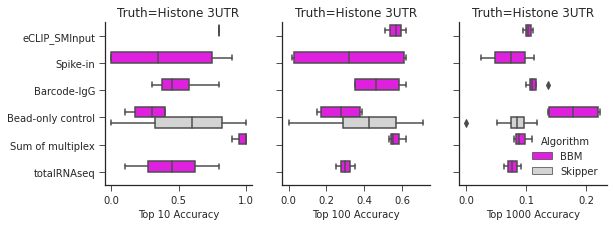

In [13]:
palette = {'BBM': 'magenta',
           'Skipper': 'lightgrey'
          }
order = ['eCLIP_SMInput', 'Spike-in', 'Barcode-IgG', 'Bead-only control', 'Sum of multiplex',
         'totalRNAseq']
f, axes = plt.subplots(1,3, figsize = (9,3),sharey = True, sharex = 'col')
for i, (name, group) in enumerate(topk.groupby(by = 'k')):
    if i ==2:
        legend = True
    else:
        legend = False
    sns.boxplot(group, x = 'topk(histone)', y = 'ctrl', ax = axes[i], hue = 'Algorithm',
               palette = palette, order = order)
    
    axes[i].set_xlabel(f'Top {name} Accuracy')
    
    axes[i].set_title(f'Truth=Histone 3UTR')
    
_ = [ax.set_ylabel('') for ax in axes.flatten()]
_ = [ax.get_legend().remove() for ax in axes.flatten()[:-1]]
sns.despine()
plt.savefig(figdir / 'topk_singleplex_SLBP.pdf')